# Network inference from Brian network

In [33]:
from brian2 import *
import pandas as pd
%matplotlib inline

filename = "data_N5000_T30_aEIF_cortical"

Nneurons_obs = 30  # number of neurons whose spike trains are observed
Nneurons_tot = 5000  # number of neurons in total;
sim_t = 30*second #simulation time
rate_min = 5


set_device('cpp_standalone')
#prefs.devices.cpp_standalone.openmp_threads = 4


### Network

In [34]:
device.reinit()
device.activate()

if filename is None: #only simulate new network if required
    
    defaultclock.dt = 0.05*ms
    
    ######################
    ##### PARAMETERS #####
    ######################
    N_e = int(0.8*Nneurons_tot) #number of excitatory neurons
    N_i = Nneurons_tot - N_e #number of inhibitory neurons
    
    # neuron model parameters:
    C = 200*pF 
    gL = 10 * nS
    taum = C / gL
    EL = -70.0 * mV
    VT = -50.0 * mV
    T_ref = 5.0*ms
    DeltaT = 2.0 * mV
    Vcut = VT + 5 * DeltaT #+5*DeltaT
    
    # external stimuli
    rate = 1 * Hz
    
    # Pick an electrophysiological behaviour
    tauw, a, b, Vr = 500*ms, 1*nS, 0.04*nA, -70.0*mV 
    
    # Synapses
    pe = 0.1 #excitatory connection probability
    pi = 0.2 #inhibitory connection probability
    d = 1.0 #synaptic delay
    # Reversal potentials
    #Ee = 0*mV #reversal potential of excitatory synapses
    #Ei = -80*mV
    # synaptic strength  -> suggested to be large in Destexhe 2018 because of small network size!
    we_init = 2*(60*0.27/10)*mV
    wi_init = (-20*4.5/10)*mV
    #we_init = 1*nS  # excitatory synaptic weight
    #wi_init = 20*nS  # inhibitory synaptic weight
    taue = 2*ms
    taui = 5*ms
    
    # input parameters:
    np.random.seed(20)   
    
    print('Number of excitatory neurons:',N_e)
    print('Number of inhibitory neurons:',N_i)
    
    ######################
    ###### NETWORK #######
    ######################   
    eqs = '''
    dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + gL*(ge + gi) - w)/C : volt
    dw/dt = (a*(vm - EL) - w)/tauw : amp 
    dge/dt = -ge/taue : volt
    dgi/dt = -gi/taui : volt
    '''
    # comment: here exponential synaptic time courses
    
    # neurons
    G = NeuronGroup(Nneurons_tot, eqs,method='euler',
                    threshold='vm>Vcut',
                    reset="vm=Vr; w+=b",
                    refractory=T_ref
                   )
    
    # intial values
    G.vm = EL + (VT - EL)*np.random.rand(Nneurons_tot)
    G.ge = 0.0
    G.gi = 0.0
    
    # synapses
    Se = Synapses(G[:N_e], G, 'we: volt', on_pre='ge += we')
    Si = Synapses(G[N_e:], G, 'wi: volt', on_pre='gi += wi')
    Se.connect('i!=j', p=pe)
    Si.connect('i!=j', p=pi)
    Se.we = "we_init*rand()" # random excitatory synaptic weight (voltage)
    Si.wi = "wi_init*rand()" # random inhibitory synaptic weight
    Se.delay = d*ms
    Si.delay = d*ms
    
    # external noise
    P = PoissonInput(G, 'ge', N=1000, rate=rate, weight=20*mV)

    # spikes
    spikemon = SpikeMonitor(G, record=True)
    # voltage
    statemon = StateMonitor(G, 'vm', record=np.arange(10))
    
    # create network object
    run(sim_t, report='text')
    
    # # discard first 5 seconds
    sptimes = spikemon.t/second
    idx = sptimes > 5
    spid = spikemon.i
    sptimes = sptimes[idx]
    spid = spid[idx]
    sptimes -= 5
    statetime = statemon.t/second
    statev = statemon.vm/mV

    # weights
    Jmat = np.zeros((Nneurons_tot, Nneurons_tot))
    Jmat[Se.i,Se.j] = Se.we/mV
    Jmat[Si.i + N_e, Si.j] = Si.wi/mV
    
    # save data as pandas dataframe
    df = pd.DataFrame(columns=['spiketimes','spikeid','Nobs','Ntot','Jmat','Jmat_obs','obs_neurons','sim_time'])
    df = df.append({'spiketimes': sptimes,
                    'spikeid': np.array(spid),
                    'statetime':statetime,
                    'statev':statev,
                    'Ntot': Nneurons_tot,
                    'Jmat': Jmat,
                    'sim_time': sim_t/second
                    }, ignore_index=True)
    
    filename = 'data_N'+str(Nneurons_tot)+'_T'+str(int(sim_t/second))+'_aEIF_cortical'
    print('File saved: %s' %filename)
    df.to_pickle(filename+'.pkl')
else:
    print("Loading results from file: %s.pkl" %filename)

Loading results from file: data_N5000_T30_aEIF_cortical.pkl


### Load already existing data

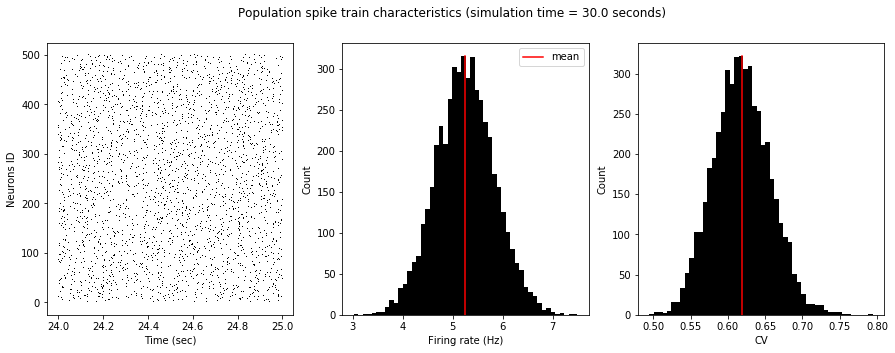

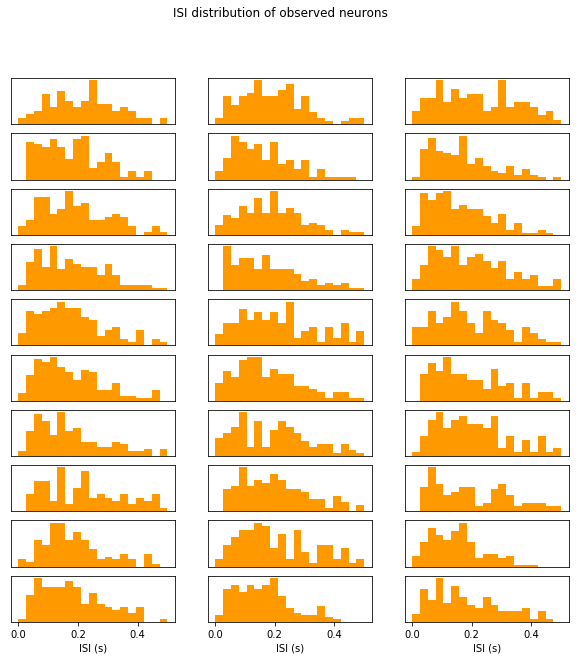

In [41]:
# load data --------------
if filename is not None:
    df = pd.read_pickle(filename+".pkl")
    
sptimes = df['spiketimes'][0]
spid = df['spikeid'][0]
Nneurons_tot = df['Ntot'][0]
Jmat = df['Jmat'][0]
sim_t = df['sim_time'][0]

# VISUALIZE SPIKE PROPERTIES OF OBSERVED NEURONS --------------
ISI = {}
ISIstat = {
    'count':np.zeros(Nneurons_tot),
    'mean': np.zeros(Nneurons_tot),
    'std':np.zeros(Nneurons_tot),
    'cv':np.zeros(Nneurons_tot)
}
for i_N in range(Nneurons_tot):
    ISI[i_N] = np.diff(sptimes[spid==i_N])
    ISIstat['count'][i_N] = len(ISI[i_N])
    if ISIstat['count'][i_N]!=0:
        ISIstat['mean'][i_N] = np.mean(ISI[i_N])
        ISIstat['std'][i_N] = np.std(ISI[i_N])
        ISIstat['cv'][i_N] = np.std(ISI[i_N])/np.mean(ISI[i_N])
    else:
        ISIstat['cv'][i_N] = 0
        
figure(figsize=(15,5))
suptitle('Population spike train characteristics (simulation time = '+str(sim_t)+' seconds)')
# raster
subplot(131)
idx = (np.array(sptimes) > (sim_t - 5) - 1) & (np.array(spid)<500)
plot(sptimes[idx],spid[idx],'k,',lw=0)
ylabel('Neurons ID')
xlabel('Time (sec)')

# firing rate
subplot(132)
fr = 1/(ISIstat['mean'])
fr[np.isinf(fr)] = 0
count,edges = np.histogram(fr, 50)
hist(fr, bins=50,color='k')
plot([np.mean(fr),np.mean(fr)],[0,np.max(count)],'r',label='mean')
xlabel('Firing rate (Hz)')
ylabel('Count')
legend()

# coefficient of variation
subplot(133)
count,edges = np.histogram(ISIstat['cv'], 50)
hist(ISIstat['cv'], bins=50,color='k')
plot([np.mean(ISIstat['cv']),np.mean(ISIstat['cv'])],[0,np.max(count)],'r',label='mean')
xlabel('CV')
ylabel('Count')
#savefig('plots/%s_population.pdf' %filename)

figure(figsize=(10,10))
suptitle('ISI distribution of observed neurons')

# change observed neurons id to neurons with at least mean fr=5 Hz
np.random.seed(100)

obs_neurons_ind = np.random.choice(np.where(fr>=1)[0],Nneurons_obs)
Jmat_obs = Jmat[obs_neurons_ind,:][:,obs_neurons_ind] #connectivity matrix of observed neurons

nb_cols = 3
nb_rows = int(ceil(Nneurons_obs/float(nb_cols)))
#x_max = np.max([np.max(ISI[i]) for i in obs_neurons_ind])

for count,ind in enumerate(obs_neurons_ind):
    subplot(nb_rows,nb_cols,count+1)
    hist(ISI[ind],np.linspace(0,0.5,20),facecolor=[1,0.6,0])
    yticks([], [])
    #xlim((0,x_max))
    if count<(nb_rows-1)*nb_cols:
        xticks(())
    else:
        xlabel('ISI (s)')
    
    
#savefig('plots/%s_ISI_dist.pdf' %filename)
show()

# into dictionary
Spt_dict = {}
for i_N,id_N in enumerate(obs_neurons_ind):
    idx = np.where(spid == id_N)[0]
    Spt_dict[i_N] = sptimes[idx]*1000 #in ms for connectivity estimation


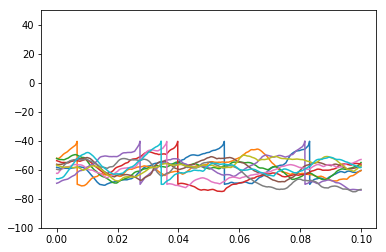

In [11]:
time = 0.1 #s
plot(statetime[statetime<time],statev[:,statetime<time].T)
ylim(-100,50)
show()

### Cross correlogram

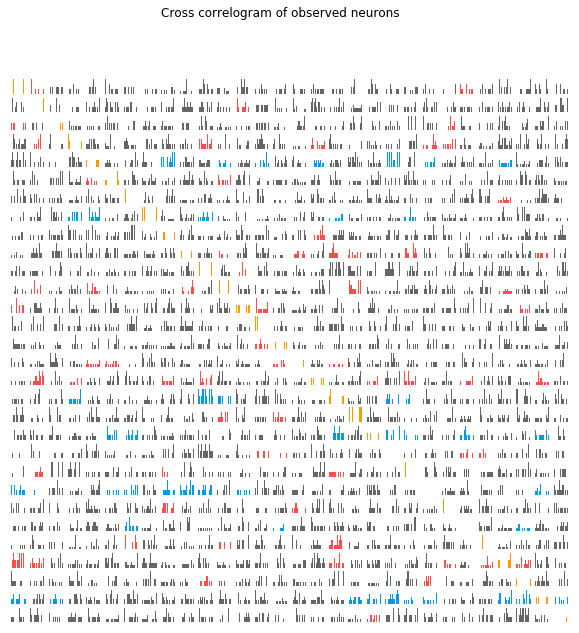

Red: neuron of row ID excites neuron of column ID


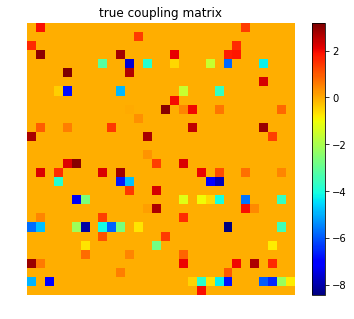

In [42]:
def crosscorr(x1,x2,steps):
    ac = np.array([np.correlate(x1[:-t],x2[t:])[0] for t in steps[steps>0]])
    ac = np.insert(ac,0,np.correlate(x1,x2)[0])
    ac2 = np.array([np.correlate(x1[t:],x2[:-t])[0] for t in abs(steps[steps<0])])
    ac = np.concatenate([ac2,ac])
    return ac

# binary spike matrix for correlation
spikes = np.zeros((Nneurons_obs,int(sim_t)*1000))
for i_N in range(Nneurons_obs):
    spikes[i_N,Spt_dict[i_N].astype(int)] = 1.0
        
        
obs_time = 300 #sec of raster to use
stepsize = 1 #ms

maxlag = 40.0 #ms
steps = np.arange(-int(maxlag),int(maxlag)+1,stepsize) #omit 0 lag

f = figure(figsize=(10,10))
suptitle('Cross correlogram of observed neurons')
sp = 1
CCG = np.zeros((Nneurons_obs,Nneurons_obs,2*int(maxlag/stepsize)+1))
for i_N in range(Nneurons_obs):
    for j_N in range(Nneurons_obs):
        x1 = spikes[i_N,:obs_time*1000]
        x2 = spikes[j_N,:obs_time*1000]

        cg = crosscorr(x1,x2,steps)
    
        if i_N==j_N:
            cg[len(cg)/2] = 0
            
        CCG[i_N,j_N,:] = cg
        
        # plot
        col = [0.4,0.4,0.4]
        if i_N==j_N:
            col = [1,0.6,0]
        elif Jmat_obs[i_N,j_N]>0:
            col = [1,0.3,0.3]
        elif Jmat_obs[i_N,j_N]<0:
            col = [0,0.6,0.9]
        
        ax = f.add_subplot(Nneurons_obs,Nneurons_obs,sp)
        bar(steps,cg,width=stepsize,facecolor=col)
        if i_N<(Nneurons_obs-1)*Nneurons_obs:
            ax.set_xticks([])
        
        ax.set_yticks([])
        box()
        sp += 1
show()

print 'Red: neuron of row ID excites neuron of column ID'

# visualize connectivity matrix    
figure(figsize=(6,5))
subplot(111)
imshow(Jmat_obs, origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet)
title('true coupling matrix')
colorbar()
axis('off')
show()    

### Connectivity estimation

In [43]:
import inference_methods as im
import multiprocessing

# generate data with other method for comparison
params = dict()
# neuron model parameters:
params['tau_m'] = 20.0  # ms, membrane time constant
params['V_r'] = -70.0  # mV, reset voltage
params['V_s'] = -50.0  # mV, spike voltage
params['Delta_T'] = 2.0  # mV, threshold slope factor (set 0 for LIF model, 
                         #                                >0 for EIF model)  
params['V_T'] = -50.0  # mV, effective threshold voltage (only used for EIF)
params['T_ref'] = 5.0  # ms, refractory duration

d = 1.0  # ms, delay# parameters for estimation (method 1a)
params['pISI_method'] = 'fourier'
f_max = 2000.0 # Hz, determines resolution (accuracy) of ISI density; 
               # 1k seems sufficient in many cases, for finer resolution try 2k or 4k
d_freq = 0.25 # Hz, spacing of frequency grid
d_V = 0.025  # mV, spacing of voltage grid
params['V_lb'] = -150.0  # mV, lower bound
params['V_vals'] = np.arange(params['V_lb'],params['V_s']+d_V/2,d_V)
params['freq_vals'] = np.arange(0.0, f_max+d_freq/2, d_freq)/1000  # kHz
params['V_r_idx'] = np.argmin(np.abs(params['V_vals']-params['V_r'])) 
                    # index of reset voltage on grid, this should be a grid point
                    
# parameters for estimation when using the finite volume method instead of the 
# Fourier method to calculate p_ISI^1, which is optional (and often faster)
use_fvm = True  # False: using Fourier method
if use_fvm:
    params['pISI_method'] = 'fvm' 
    d_V = 0.025  # mV, spacing of voltage grid
    params['V_lb'] = -150.0  # mV, lower bound
    params['V_vals'] = np.arange(params['V_lb'],params['V_s']+d_V/2,d_V)
    params['V_r_idx'] = np.argmin(np.abs(params['V_vals']-params['V_r'])) 
                        # index of reset voltage on grid, this should be a grid point
    params['neuron_model'] = 'LIF'
    params['integration_method'] = 'implicit'
    params['N_centers_fvm'] = 1000  # number of centers for voltage discretization
    params['fvm_v_init'] = 'delta'  # voltage density initialization
    params['fvm_delta_peak'] = params['V_r']  # location of initial density peak
    params['fvm_dt'] = 0.1  # ms, time step for finite volume method
                            # 0.1 seems ok, prev. def.: 0.05 ms 

sigma_init = 3.0  # initial sigma value (initial mu value will be determined by 
                  # sigma_init and empirical mean ISI)
N_tpert = 300  # determines spacing of (potential) perturbation times within ISIs
               # due to coupling; def.: 300            
J_bnds = (-3.0, 3.0)  # mV, min./max. coupling strength 
N_procs = int(5.0*multiprocessing.cpu_count()/6)  # number of parallel processes                
             
# ESTIMATE PARAMETERS from spike trains -----------------------------------
start = time.time()
N = len(Spt_dict.keys())
args_fixed = (Spt_dict, d, sigma_init, N_tpert, J_bnds, Jmat, params)
arg_tuple_list = [(iN, N, args_fixed) for iN in range(N)]    
                                                          
print('starting estimation using {} parallel processes'.format(N_procs))
# e.g., one process for each neuron
print('')
print('likelihood optimization can take several minutes...')
pool = multiprocessing.Pool(N_procs)
if use_fvm:
    result = pool.imap_unordered(im.Jij_estim_wrapper_v1, arg_tuple_list)
else:
    result = pool.imap_unordered(im.Jij_estim_wrapper_v2, arg_tuple_list)

D = {}
obs_neurons_id = list(Spt_dict.keys())
D['J_true'] = Jmat_obs.T
D['mu_estim'] = np.zeros(N)*np.nan
D['sigma_estim'] = np.zeros(N)*np.nan
D['logl_uncoupled'] = np.zeros(N)*np.nan
D['J_estim'] = np.zeros((N,N))
D['logl_coupled'] = np.zeros((N,N))*np.nan

finished = 0 
for i_N, mu_estim, sigma_estim, logl_uncoupled, \
    J_estim_row, logl_coupled_row in result:
    finished += 1
    print(('{count} of {tot} estimation parts completed').
          format(count=finished, tot=N)) 
    D['mu_estim'][i_N] = mu_estim
    D['sigma_estim'][i_N] = sigma_estim
    D['logl_uncoupled'][i_N] = logl_uncoupled
    D['J_estim'][i_N,:] = J_estim_row
    D['logl_coupled'][i_N,:] = logl_coupled_row

pool.close()
Pcc = np.corrcoef(np.ravel(D['J_estim']),np.ravel(D['J_true']))
print('')
print('estimation took {dur}s, corr.-coeff. = {cc}'.format(
       dur=np.round(time.time() - start,2), cc=Pcc[0,1]) )
print('')
         




starting estimation using 3 parallel processes

likelihood optimization can take several minutes...
mean ISI of neuron 1 = 242.32
mean ISI of neuron 2 = 203.51
mean ISI of neuron 3 = 237.42
neuron 2: mu_estim = -3.01, sigma_estim = 1.71
neuron 1: mu_estim = -3.18, sigma_estim = 2.11
neuron 3: mu_estim = -3.19, sigma_estim = 2.17
precalculations for neuron 2 took 140.43s
1 of 30 estimation parts completed
mean ISI of neuron 4 = 186.09
neuron 4: mu_estim = -2.88, sigma_estim = 1.35
precalculations for neuron 1 took 186.62s
2 of 30 estimation parts completed
mean ISI of neuron 5 = 165.51
neuron 5: mu_estim = -2.95, sigma_estim = 1.66
precalculations for neuron 3 took 223.29s
3 of 30 estimation parts completed
mean ISI of neuron 6 = 176.25
neuron 6: mu_estim = -2.92, sigma_estim = 1.49
precalculations for neuron 4 took 126.34s
4 of 30 estimation parts completed
mean ISI of neuron 7 = 198.54
neuron 7: mu_estim = -3.19, sigma_estim = 2.3
precalculations for neuron 5 took 133.27s
5 of 30 esti